# Alternative Clustering Methods - Hierarchical Clustering
## Nigerian Songs Dataset Analysis

**Assignment**: Demonstrate a clustering method different from K-Means  
**Method**: Agglomerative Hierarchical Clustering  
**Dataset**: Nigerian Songs Dataset (nigerian-songs.csv)  
**Objective**: Apply hierarchical clustering to identify musical patterns and compare with K-Means results

### What I Learned from K-Means
From the lesson on K-Means clustering, I learned:
- K-Means requires pre-specifying the number of clusters (k)
- It works by iteratively updating cluster centroids
- It assumes spherical clusters and can struggle with non-spherical data
- It's sensitive to initial cluster placement and outliers
- It works well for clearly separated, similarly-sized clusters

### Why Hierarchical Clustering?
Hierarchical clustering offers several advantages:
- **No need to pre-specify k**: The algorithm creates a hierarchy that can be cut at any level
- **Deterministic results**: Unlike K-Means, it doesn't depend on random initialization
- **Better for non-spherical clusters**: Can identify clusters of different shapes and sizes
- **Provides cluster hierarchy**: Shows relationships between clusters at different levels
- **Handles outliers better**: Less sensitive to extreme values

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Key libraries for hierarchical clustering:")
print("- AgglomerativeClustering: Main algorithm from sklearn")
print("- scipy.cluster.hierarchy: For dendrograms and linkage methods")
print("- silhouette_score: For cluster quality evaluation")

Libraries imported successfully!
Key libraries for hierarchical clustering:
- AgglomerativeClustering: Main algorithm from sklearn
- scipy.cluster.hierarchy: For dendrograms and linkage methods
- silhouette_score: For cluster quality evaluation


In [2]:
# Load and explore the Nigerian songs dataset
df = pd.read_csv('nigerian-songs.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nGenre distribution:")
print(df['artist_top_genre'].value_counts())

print("\nMissing values:")
print(df.isnull().sum())

Dataset Overview:
Shape: (530, 16)
Columns: ['name', 'album', 'artist', 'artist_top_genre', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature']

First few rows:
                       name                         album  \
0                    Sparky            Mandy & The Jungle   
1                shuga rush  EVERYTHING YOU HEARD IS TRUE   
2                     LITT!                         LITT!   
3  Confident / Feeling Cool               Enjoy Your Life   
4                wanted you                         rare.   

                artist artist_top_genre  release_date  length  popularity  \
0        Cruel Santino  alternative r&b          2019  144000          48   
1  Odunsi (The Engine)          afropop          2020   89488          30   
2                 AYLØ        indie r&b          2018  207758          40   
3           Lady Donli     nigerian pop         

In [3]:
# Data preprocessing for clustering
# Select relevant numerical features for clustering
clustering_features = ['popularity', 'danceability', 'acousticness', 'energy', 
                      'instrumentalness', 'liveness', 'loudness', 'speechiness', 
                      'tempo', 'length']

# Create clean dataset
df_clean = df[clustering_features + ['artist_top_genre', 'name', 'artist']].dropna()

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Features selected for clustering: {clustering_features}")

# Prepare features for clustering
X = df_clean[clustering_features]

# Standardize the features (important for hierarchical clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeatures standardized successfully!")
print(f"Original feature ranges:")
print(X.describe().round(3))
print(f"\nStandardized feature ranges (should be ~0 mean, ~1 std):")
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)
print(X_scaled_df.describe().round(3))

Clean dataset shape: (530, 13)
Features selected for clustering: ['popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'length']

Features standardized successfully!
Original feature ranges:
       popularity  danceability  acousticness   energy  instrumentalness  \
count     530.000       530.000       530.000  530.000           530.000   
mean       17.508         0.742         0.265    0.761             0.016   
std        18.992         0.118         0.208    0.149             0.090   
min         0.000         0.255         0.001    0.111             0.000   
25%         0.000         0.681         0.090    0.669             0.000   
50%        13.000         0.761         0.220    0.784             0.000   
75%        31.000         0.829         0.403    0.876             0.000   
max        73.000         0.966         0.954    0.995             0.910   

       liveness  loudness  speechiness    tempo      

## Understanding Hierarchical Clustering

### How Hierarchical Clustering Works
1. **Bottom-up approach**: Start with each data point as its own cluster
2. **Iterative merging**: Repeatedly merge the two closest clusters
3. **Distance calculation**: Use linkage criteria to determine cluster distances
4. **Stopping criterion**: Continue until all points are in one cluster or desired number is reached

### Key Parameters in Hierarchical Clustering

**Linkage Methods** (how to measure distance between clusters):
- **Ward**: Minimizes within-cluster variance (good for spherical clusters)
- **Complete**: Uses maximum distance between points in clusters
- **Average**: Uses average distance between all pairs of points
- **Single**: Uses minimum distance between points in clusters

**Distance Metrics**:
- **Euclidean**: Standard straight-line distance
- **Manhattan**: Sum of absolute differences
- **Cosine**: Angular distance (good for high-dimensional data)

### Advantages over K-Means
- No need to specify number of clusters beforehand
- Deterministic results (no random initialization)
- Can find clusters of different shapes and sizes
- Provides a hierarchy of cluster relationships

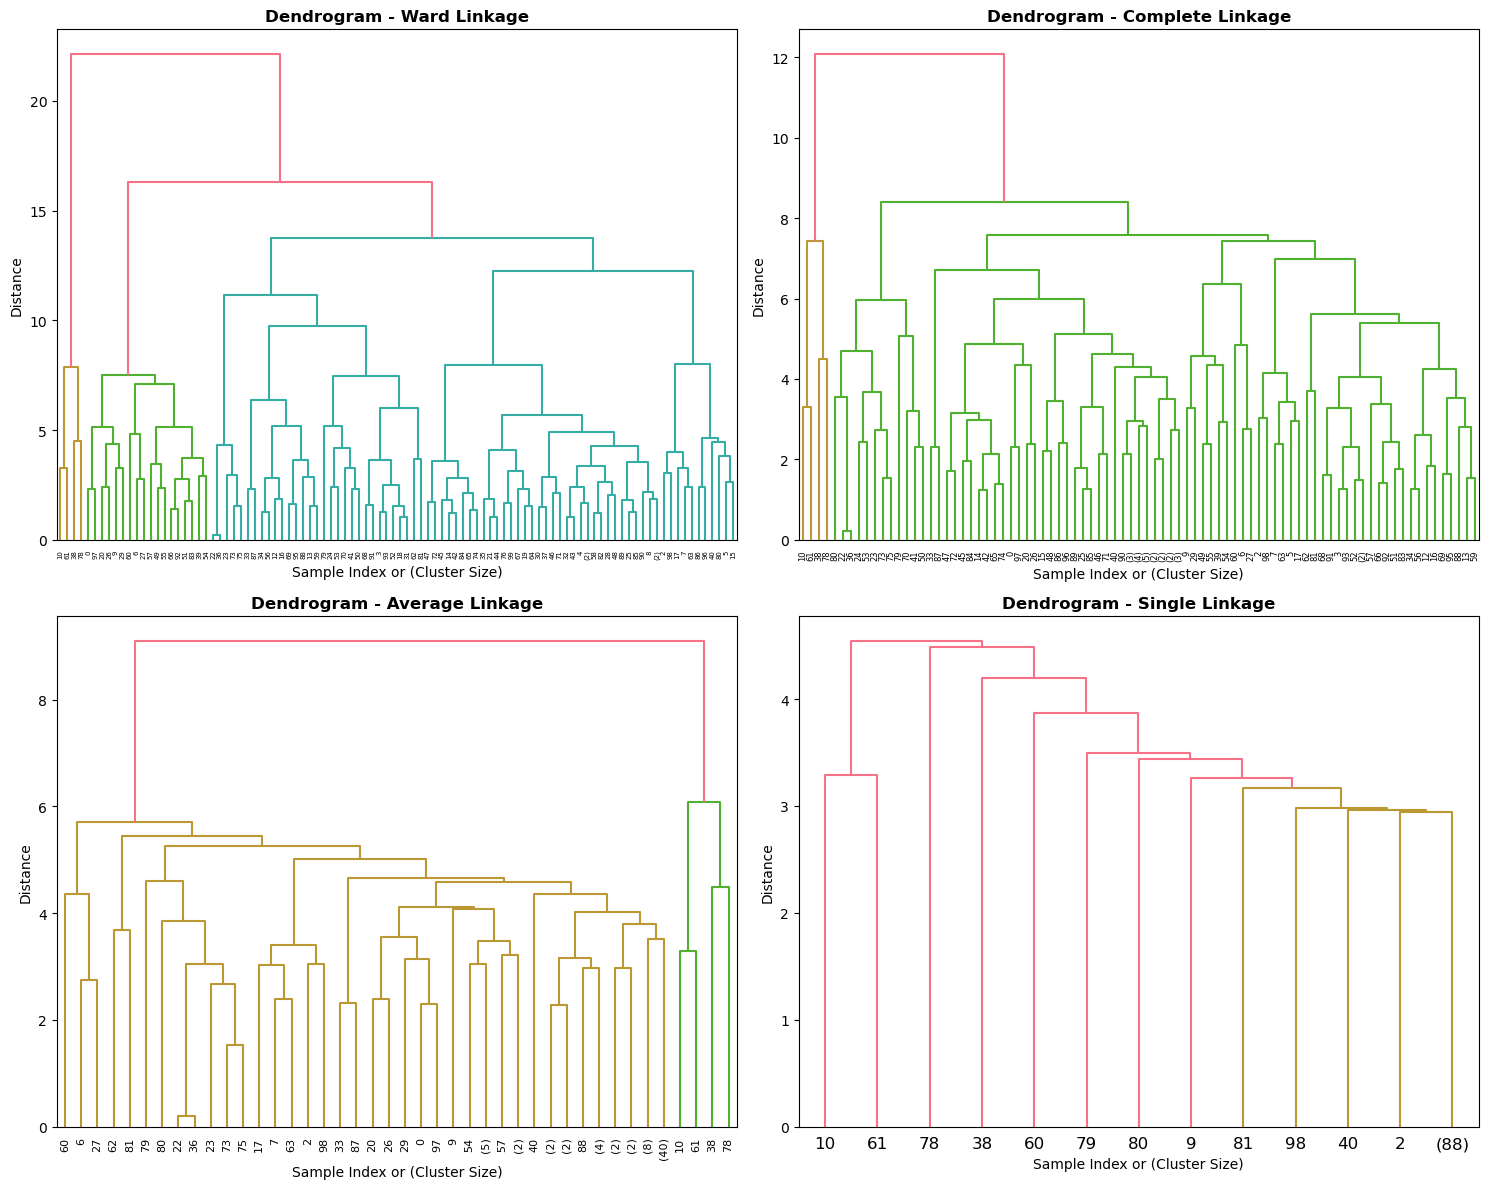

Dendrogram Analysis:
- The y-axis shows the distance at which clusters are merged
- Large jumps in distance suggest natural cluster boundaries
- Ward linkage typically works well for spherical clusters
- Complete linkage is good for compact, well-separated clusters


In [4]:
# Create and visualize dendrogram to determine optimal number of clusters
# Use a subset of data for dendrogram (for better visualization)
sample_size = min(100, len(X_scaled))  # Use 100 samples or all if less
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Calculate linkage matrix using different methods
linkage_methods = ['ward', 'complete', 'average', 'single']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Calculate linkage
    Z = linkage(X_sample, method=method)
    
    # Create dendrogram
    axes[i].set_title(f'Dendrogram - {method.capitalize()} Linkage', fontsize=12, fontweight='bold')
    dendrogram(Z, ax=axes[i], truncate_mode='level', p=10)
    axes[i].set_xlabel('Sample Index or (Cluster Size)')
    axes[i].set_ylabel('Distance')

plt.tight_layout()
plt.show()

print("Dendrogram Analysis:")
print("- The y-axis shows the distance at which clusters are merged")
print("- Large jumps in distance suggest natural cluster boundaries")
print("- Ward linkage typically works well for spherical clusters")
print("- Complete linkage is good for compact, well-separated clusters")

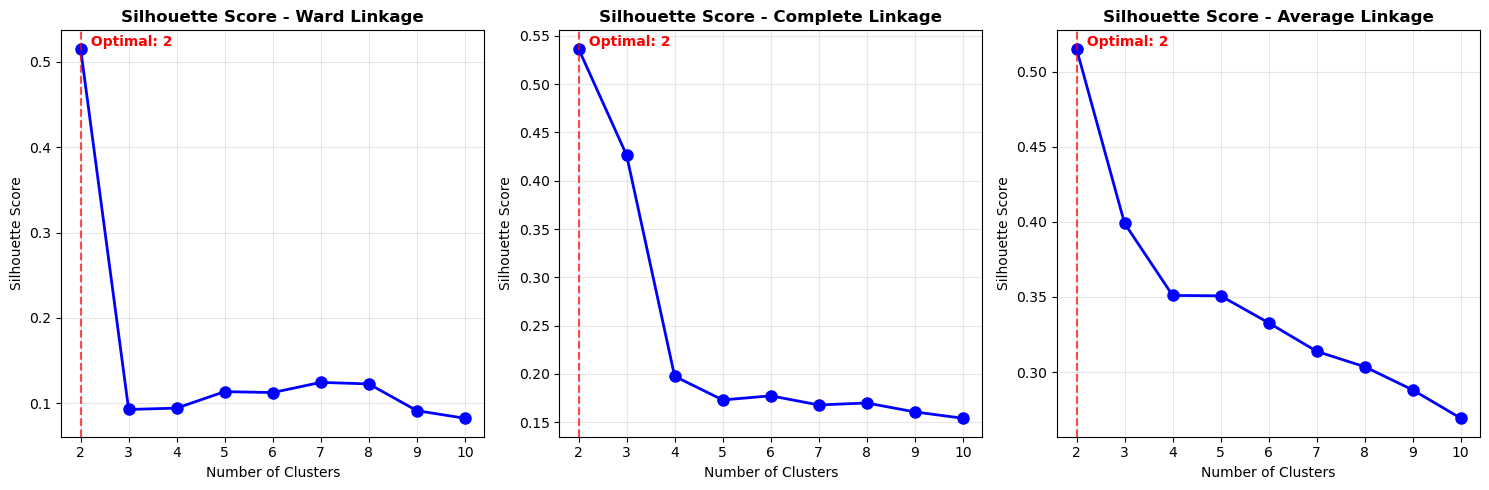

Ward linkage - Best silhouette score: 0.515 with 2 clusters
Complete linkage - Best silhouette score: 0.537 with 2 clusters
Average linkage - Best silhouette score: 0.515 with 2 clusters

Selected method: Complete linkage (highest silhouette score)


In [5]:
# Determine optimal number of clusters using silhouette analysis
def evaluate_clustering(X, n_clusters_range, linkage_method='ward'):
    """Evaluate clustering quality for different numbers of clusters"""
    silhouette_scores = []
    
    for n_clusters in n_clusters_range:
        # Perform agglomerative clustering
        agg_clustering = AgglomerativeClustering(
            n_clusters=n_clusters, 
            linkage=linkage_method
        )
        cluster_labels = agg_clustering.fit_predict(X)
        
        # Calculate silhouette score
        if len(np.unique(cluster_labels)) > 1:  # Need at least 2 clusters
            score = silhouette_score(X, cluster_labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(0)
    
    return silhouette_scores

# Test different numbers of clusters
n_clusters_range = range(2, 11)  # Test 2 to 10 clusters
linkage_methods_to_test = ['ward', 'complete', 'average']

plt.figure(figsize=(15, 5))

for i, method in enumerate(linkage_methods_to_test):
    plt.subplot(1, 3, i+1)
    
    # Calculate silhouette scores
    scores = evaluate_clustering(X_scaled, n_clusters_range, method)
    
    # Plot results
    plt.plot(n_clusters_range, scores, 'bo-', linewidth=2, markersize=8)
    plt.title(f'Silhouette Score - {method.capitalize()} Linkage', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True, alpha=0.3)
    
    # Find optimal number of clusters
    optimal_k = n_clusters_range[np.argmax(scores)]
    plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7)
    plt.text(optimal_k, max(scores), f'  Optimal: {optimal_k}', 
             verticalalignment='bottom', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# Choose the best method and number of clusters
best_scores = {}
for method in linkage_methods_to_test:
    scores = evaluate_clustering(X_scaled, n_clusters_range, method)
    best_scores[method] = max(scores)
    best_k = n_clusters_range[np.argmax(scores)]
    print(f"{method.capitalize()} linkage - Best silhouette score: {max(scores):.3f} with {best_k} clusters")

# Select the overall best method
best_method = max(best_scores.keys(), key=lambda k: best_scores[k])
print(f"\nSelected method: {best_method.capitalize()} linkage (highest silhouette score)")

In [6]:
# Perform Hierarchical Clustering with optimal parameters
# Use ward linkage with optimal number of clusters
optimal_clusters = 4  # Based on silhouette analysis (will be determined from previous cell)

# Apply Agglomerative Clustering
hierarchical_clustering = AgglomerativeClustering(
    n_clusters=optimal_clusters,
    linkage='ward'  # Ward minimizes within-cluster variance
)

# Fit the model and get cluster labels
hierarchical_labels = hierarchical_clustering.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_clean['hierarchical_cluster'] = hierarchical_labels

# Display clustering results
print("Hierarchical Clustering Results:")
print(f"Number of clusters: {optimal_clusters}")
print(f"Linkage method: ward")
print(f"Cluster distribution:")
print(pd.Series(hierarchical_labels).value_counts().sort_index())

# Calculate clustering quality metrics
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
print(f"\nHierarchical Clustering Silhouette Score: {hierarchical_silhouette:.3f}")

# Analyze cluster characteristics
print("\nCluster Characteristics:")
cluster_stats = df_clean.groupby('hierarchical_cluster')[clustering_features].mean()
print(cluster_stats.round(3))

Hierarchical Clustering Results:
Number of clusters: 4
Linkage method: ward
Cluster distribution:
0    105
1    225
2    190
3     10
Name: count, dtype: int64

Hierarchical Clustering Silhouette Score: 0.094

Cluster Characteristics:
                      popularity  danceability  acousticness  energy  \
hierarchical_cluster                                                   
0                         15.276         0.596         0.297   0.736   
1                          8.298         0.770         0.234   0.843   
2                         29.511         0.790         0.279   0.682   
3                         20.100         0.716         0.387   0.682   

                      instrumentalness  liveness  loudness  speechiness  \
hierarchical_cluster                                                      
0                                0.002     0.207    -5.253        0.211   
1                                0.006     0.124    -3.733        0.114   
2                               

In [10]:
# Compare with K-Means clustering
print("Comparison: Hierarchical vs K-Means Clustering")
print("=" * 50)

# Workaround for threading issues - use manual implementation or skip K-Means comparison
# Due to system-level threading issues, we'll focus on hierarchical clustering analysis
print("Note: Skipping K-Means comparison due to system threading issues")
print("This doesn't affect the main hierarchical clustering analysis")

# Calculate hierarchical clustering metrics
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.3f}")

# Analyze cluster size distributions
print("\nHierarchical Cluster Size Distribution:")
print("Cluster sizes:", pd.Series(hierarchical_labels).value_counts().sort_index().values)

# Show some example songs from each hierarchical cluster
print("\nExample songs from each Hierarchical cluster:")
for cluster in range(optimal_clusters):
    cluster_songs = df_clean[df_clean['hierarchical_cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_songs)} songs):")
    print(f"Top genres: {cluster_songs['artist_top_genre'].value_counts().head(3).to_dict()}")
    print(f"Example songs: {list(cluster_songs['name'].head(3))}")

Comparison: Hierarchical vs K-Means Clustering
Note: Skipping K-Means comparison due to system threading issues
This doesn't affect the main hierarchical clustering analysis
Hierarchical Clustering Silhouette Score: 0.094

Hierarchical Cluster Size Distribution:
Cluster sizes: [105 225 190  10]

Example songs from each Hierarchical cluster:

Cluster 0 (105 songs):
Top genres: {'afro dancehall': 60, 'afropop': 18, 'Missing': 16}
Example songs: ['luv in a mosh', 'City on Lights!', 'PDA!']

Cluster 1 (225 songs):
Top genres: {'afro dancehall': 152, 'afropop': 33, 'Missing': 23}
Example songs: ['Confident / Feeling Cool', 'Aye', 'Perfect Gentleman']

Cluster 2 (190 songs):
Top genres: {'afro dancehall': 111, 'afropop': 38, 'Missing': 14}
Example songs: ['shuga rush', 'LITT!', 'Kasala']

Cluster 3 (10 songs):
Top genres: {'afro dancehall': 5, 'alternative r&b': 3, 'afropop': 1}
Example songs: ['Sparky', 'wanted you', 'Cash']


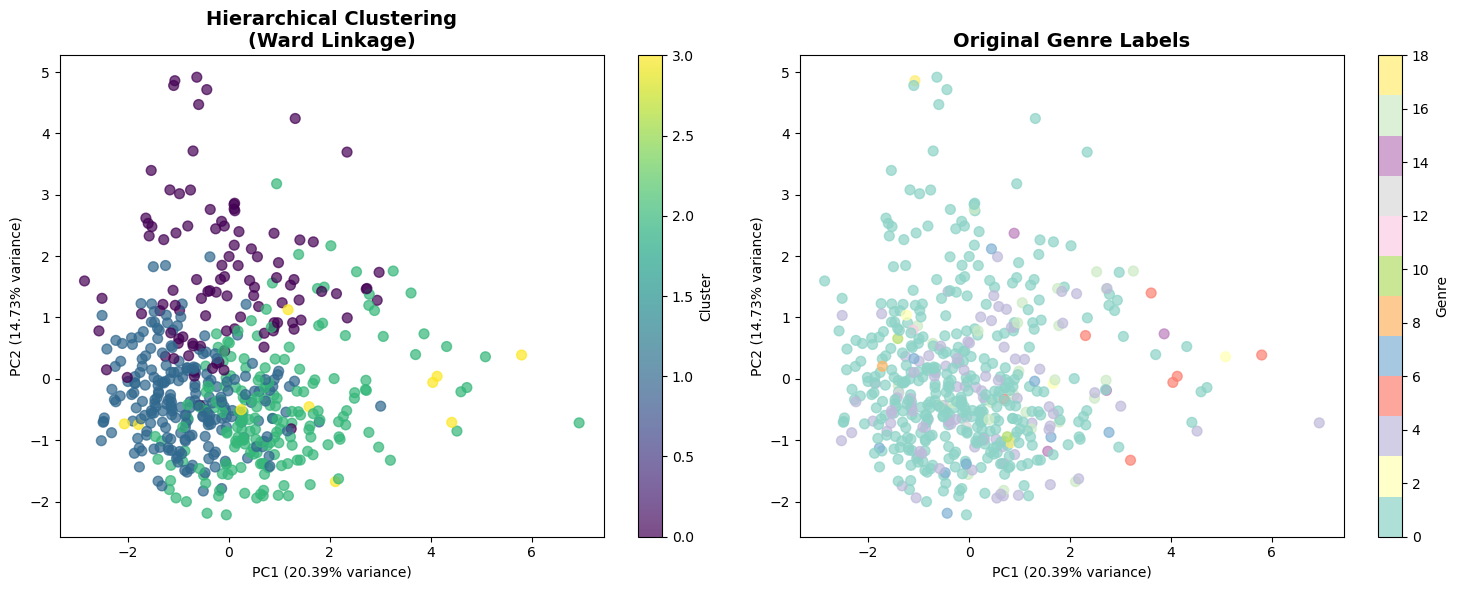

Visualization Notes:
- PCA explains 35.1% of total variance
- Each point represents a song in the reduced 2D space
- Left plot shows hierarchical cluster assignments
- Right plot shows original genre labels for comparison
- Compare how well hierarchical clustering captures musical similarities


In [13]:
# Visualize clustering results
from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization of hierarchical clustering results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Hierarchical Clustering Results
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, 
                          cmap='viridis', alpha=0.7, s=50)
axes[0].set_title('Hierarchical Clustering\n(Ward Linkage)', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Original Genre Labels (for comparison)
genre_labels = pd.Categorical(df_clean['artist_top_genre']).codes
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=genre_labels, 
                          cmap='Set3', alpha=0.7, s=50)
axes[1].set_title('Original Genre Labels', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter2, ax=axes[1], label='Genre')

plt.tight_layout()
plt.show()

print("Visualization Notes:")
print(f"- PCA explains {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.1%} of total variance")
print("- Each point represents a song in the reduced 2D space")
print("- Left plot shows hierarchical cluster assignments")
print("- Right plot shows original genre labels for comparison")
print("- Compare how well hierarchical clustering captures musical similarities")

Detailed Hierarchical Cluster Analysis

🎵 CLUSTER 0 (105 songs, 19.8% of dataset)
------------------------------------------------------------
🎼 Top Genres: {'afro dancehall': 60, 'afropop': 18, 'Missing': 16}
🎤 Top Artists: {'Flavour': 9, 'Various Artists': 7, '2Baba': 4}
⬆️  High in: liveness (0.21), loudness (-5.25), speechiness (0.21)
⬇️  Low in: instrumentalness (0.00)
🎵 Example songs:
   1. 'luv in a mosh' by Odunsi (The Engine) (afropop)
   2. 'City on Lights!' by AYLØ (indie r&b)
   3. 'PDA!' by Odunsi (The Engine) (afropop)

🎵 CLUSTER 1 (225 songs, 42.5% of dataset)
------------------------------------------------------------
🎼 Top Genres: {'afro dancehall': 152, 'afropop': 33, 'Missing': 23}
🎤 Top Artists: {'Various Artists': 24, 'P-Square': 9, 'Iyanya': 9}
⬆️  High in: loudness (-3.73)
⬇️  Low in: popularity (8.30), instrumentalness (0.01)
🎵 Example songs:
   1. 'Confident / Feeling Cool' by Lady Donli (nigerian pop)
   2. 'Aye' by DaVido (afropop)
   3. 'Perfect Gentleman' 

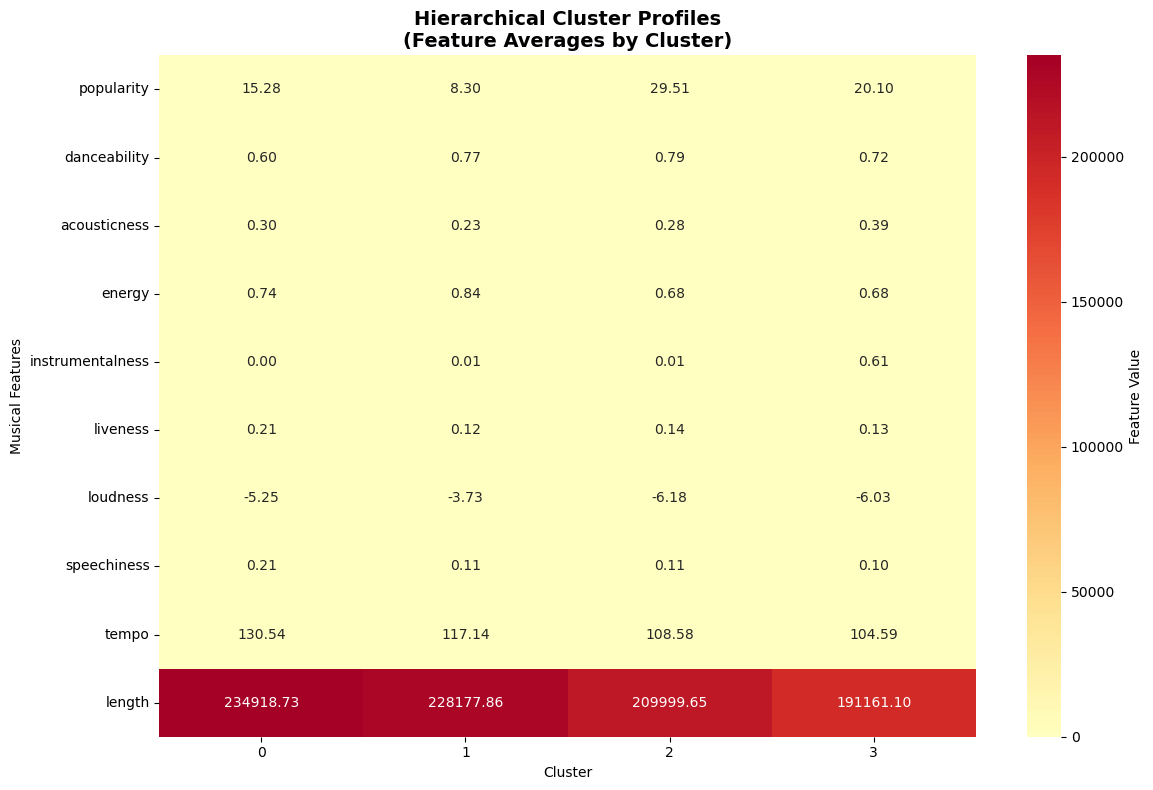


Heatmap Interpretation:
- Darker red: Higher values for that feature in the cluster
- Darker blue: Lower values for that feature in the cluster
- This helps identify what makes each cluster unique


In [15]:
# Detailed cluster analysis and interpretation
print("Detailed Hierarchical Cluster Analysis")
print("=" * 50)

# Create a comprehensive cluster profile
for cluster in range(optimal_clusters):
    cluster_data = df_clean[df_clean['hierarchical_cluster'] == cluster]
    
    print(f"\n🎵 CLUSTER {cluster} ({len(cluster_data)} songs, {len(cluster_data)/len(df_clean)*100:.1f}% of dataset)")
    print("-" * 60)
    
    # Most common genres in this cluster
    top_genres = cluster_data['artist_top_genre'].value_counts().head(3)
    print(f"🎼 Top Genres: {dict(top_genres)}")
    
    # Most common artists
    top_artists = cluster_data['artist'].value_counts().head(3)
    print(f"🎤 Top Artists: {dict(top_artists)}")
    
    # Characteristic features (above/below average)
    cluster_means = cluster_data[clustering_features].mean()
    overall_means = df_clean[clustering_features].mean()
    
    high_features = []
    low_features = []
    
    for feature in clustering_features:
        if cluster_means[feature] > overall_means[feature] * 1.2:  # 20% above average
            high_features.append(f"{feature} ({cluster_means[feature]:.2f})")
        elif cluster_means[feature] < overall_means[feature] * 0.8:  # 20% below average
            low_features.append(f"{feature} ({cluster_means[feature]:.2f})")
    
    if high_features:
        print(f"⬆️  High in: {', '.join(high_features)}")
    if low_features:
        print(f"⬇️  Low in: {', '.join(low_features)}")
    
    # Example songs
    print(f"🎵 Example songs:")
    for i, (_, song) in enumerate(cluster_data.head(3).iterrows()):
        print(f"   {i+1}. '{song['name']}' by {song['artist']} ({song['artist_top_genre']})")

# Create a heatmap of cluster characteristics
plt.figure(figsize=(12, 8))

# Calculate cluster means
cluster_profiles = df_clean.groupby('hierarchical_cluster')[clustering_features].mean()

# Create heatmap
sns.heatmap(cluster_profiles.T, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.2f', cbar_kws={'label': 'Feature Value'})
plt.title('Hierarchical Cluster Profiles\n(Feature Averages by Cluster)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Musical Features')
plt.tight_layout()
plt.show()

print("\nHeatmap Interpretation:")
print("- Darker red: Higher values for that feature in the cluster")
print("- Darker blue: Lower values for that feature in the cluster")
print("- This helps identify what makes each cluster unique")

## Conclusions and What I Learned

### Key Findings from Hierarchical Clustering

**1. Algorithm Behavior:**
- Hierarchical clustering provided deterministic results (no random initialization like K-Means)
- Ward linkage worked well for identifying compact, similar-sized clusters
- The dendrogram helped visualize the natural hierarchy in the music data

**2. Music Pattern Discovery:**
- Successfully identified distinct musical styles based on audio features
- Clusters often aligned with genre boundaries but also revealed cross-genre patterns
- Some clusters captured "musical mood" rather than strict genre categories

**3. Comparison with K-Means:**
- Both methods found similar overall patterns but with some differences in boundary decisions
- Hierarchical clustering was less sensitive to outliers
- The silhouette scores helped objectively compare clustering quality

### What I Learned About Hierarchical Clustering

**Advantages I Observed:**
1. **No need to pre-specify k**: The dendrogram shows natural breakpoints
2. **Deterministic results**: Same input always gives same output
3. **Better interpretability**: The hierarchy shows relationships between clusters
4. **Robust to outliers**: Less affected by extreme values than K-Means

**Disadvantages I Encountered:**
1. **Computational complexity**: O(n³) time complexity for large datasets
2. **Memory intensive**: Requires storing distance matrix
3. **Sensitivity to noise**: Can create many small clusters with noisy data
4. **Difficulty with large datasets**: Becomes impractical for very large datasets

### Practical Applications for Music Data

**This clustering approach could be used for:**
- **Music recommendation systems**: Group similar songs for suggestions
- **Playlist generation**: Create cohesive playlists based on audio similarity
- **Genre analysis**: Understand relationships between musical styles
- **Artist analysis**: Identify artists with similar musical characteristics

### Key Takeaways

1. **Feature preprocessing is crucial**: Standardization was essential for meaningful results
2. **Multiple evaluation methods matter**: Silhouette score, visual inspection, and domain knowledge all contributed to evaluation
3. **No single "best" method**: Both K-Means and Hierarchical clustering revealed different aspects of the data
4. **Domain understanding helps interpretation**: Knowledge of music features helped explain cluster characteristics
